## Pouch Cell Model Parameter Identification

In this notebook, we present the single particle model with a two dimensional current collector. This is achieved via the potential-pair models introduced in [[1]](10.1149/1945-7111/abbce4) as implemented in PyBaMM. At a high-level this is accomplished as a potential-pair model which is resolved across the discretised spatial locations.

### Setting up the Environment

Before we begin, we need to ensure that we have all the necessary tools. We will install PyBOP from its development branch and upgrade some dependencies:

In [1]:
%pip install --upgrade pip ipywidgets
%pip install pybop -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Importing Libraries

With the environment set up, we can now import PyBOP alongside other libraries we will need:

In [2]:
import numpy as np
import plotly.graph_objects as go

import pybop

### Generate Synthetic Data

To demonstrate parameter estimation, we first need some data. We will generate synthetic data using the PyBOP forward model, which requires defining a parameter set and the model itself.

#### Defining Parameters and Model

We start by creating an example parameter set and then instantiate the single-particle model (SPM):

In [3]:
parameter_set = pybop.ParameterSet.pybamm("Marquis2019")
parameter_set.update(
    {
        "Negative electrode active material volume fraction": 0.495,
        "Positive electrode active material volume fraction": 0.612,
    }
)
model = pybop.lithium_ion.SPM(
    parameter_set=parameter_set,
    options={"current collector": "potential pair", "dimensionality": 2},
)

### Update the number of spatial locations

Next, we update the number of spatial locations to solve the potential-pair model,

In [4]:
model.var_pts["y"] = 5
model.var_pts["z"] = 5

### Simulating Forward Model

We can then simulate the model using the `predict` method, with a default constant current to generate voltage data.

In [5]:
t_eval = np.arange(0, 900, 2)
values = model.predict(t_eval=t_eval)

### Adding Noise to Voltage Data

To make the parameter estimation more realistic, we add Gaussian noise to the data.

In [6]:
sigma = 0.001
corrupt_values = values["Voltage [V]"].data + np.random.normal(0, sigma, len(t_eval))

## Identify the Parameters

We will now set up the parameter estimation process by defining the datasets for optimisation and selecting the model parameters we wish to estimate.

### Creating Optimisation Dataset

The dataset for optimisation is composed of time, current, and the noisy voltage data:

In [7]:
dataset = pybop.Dataset(
    {
        "Time [s]": t_eval,
        "Current function [A]": values["Current [A]"].data,
        "Voltage [V]": corrupt_values,
    }
)

### Defining Parameters to Estimate

We select the parameters for estimation and set up their prior distributions and bounds:

In [8]:
parameters = [
    pybop.Parameter(
        "Negative electrode active material volume fraction",
        prior=pybop.Gaussian(0.7, 0.05),
        bounds=[0.45, 0.9],
    ),
    pybop.Parameter(
        "Positive electrode active material volume fraction",
        prior=pybop.Gaussian(0.58, 0.05),
        bounds=[0.5, 0.8],
    ),
]

For plotting purposed, we want additional variables to be stored in the problem class. These are defined as,

In [9]:
additional_variables = [
    "Negative current collector potential [V]",
    "Positive current collector potential [V]",
]

### Setting up the Optimisation Problem

With the datasets and parameters defined, we can set up the optimisation problem, its cost function, and the optimiser.

In [10]:
problem = pybop.FittingProblem(
    model, parameters, dataset, additional_variables=additional_variables
)
cost = pybop.SumSquaredError(problem)
optim = pybop.Optimisation(cost, optimiser=pybop.CMAES)
optim.set_max_iterations(30)

### Running the Optimisation

We proceed to run the CMA-ES optimisation algorithm to estimate the parameters:

In [11]:
x, final_cost = optim.run()

### Viewing the Estimated Parameters

After the optimisation, we can examine the estimated parameter values:

In [12]:
x  # This will output the estimated parameters

array([0.47496537, 0.61140011])

## Plotting and Visualisation

PyBOP provides various plotting utilities to visualise the results of the optimisation.

### Comparing System Response

We can quickly plot the system's response using the estimated parameters compared to the target:

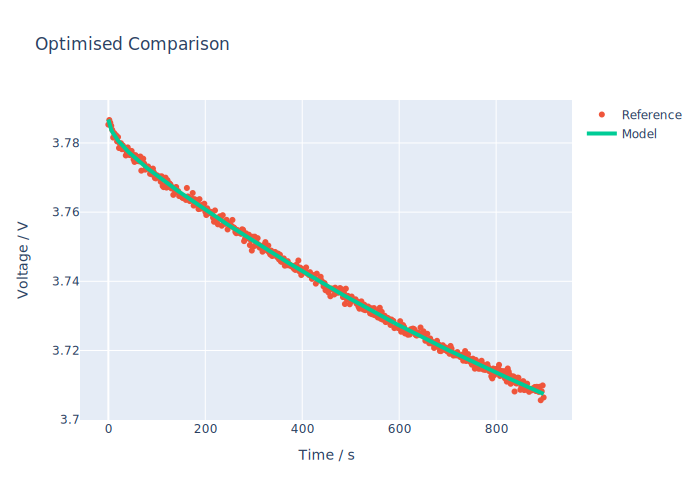

In [13]:
pybop.quick_plot(problem, parameter_values=x, title="Optimised Comparison");

## Spatial Plotting

We can now plot the spatial variables from the solution object. First, the final negative current collector potential can be displayed. In this example, this is just a reference variable, but could be used for fitting or optimisation in the correct workflows.

In [14]:
sol = problem.evaluate(x)

go.Figure(
    [
        go.Contour(
            x=np.arange(0, model.var_pts["y"] - 1, 1),
            y=np.arange(0, model.var_pts["z"] - 1, 1),
            z=sol["Negative current collector potential [V]"][:, :, -1],
            colorscale="Viridis",
        )
    ],
    layout=dict(
        title="Negative current collector potential [V]",
        xaxis_title="x node",
        yaxis_title="y node",
        width=600,
        height=600,
    ),
)

We plot can then plot the positive current collector potential,

In [18]:
go.Figure(
    [
        go.Contour(
            x=np.arange(0, model.var_pts["y"] - 1, 1),
            y=np.arange(0, model.var_pts["z"] - 1, 1),
            z=sol["Positive current collector potential [V]"][:, :, -1],
            colorscale="Viridis",
        )
    ],
    layout=dict(
        title="Positive current collector potential [V]",
        xaxis_title="x node",
        yaxis_title="y node",
        width=600,
        height=600,
    ),
)

### Convergence and Parameter Trajectories

To assess the optimisation process, we can plot the convergence of the cost function and the trajectories of the parameters:

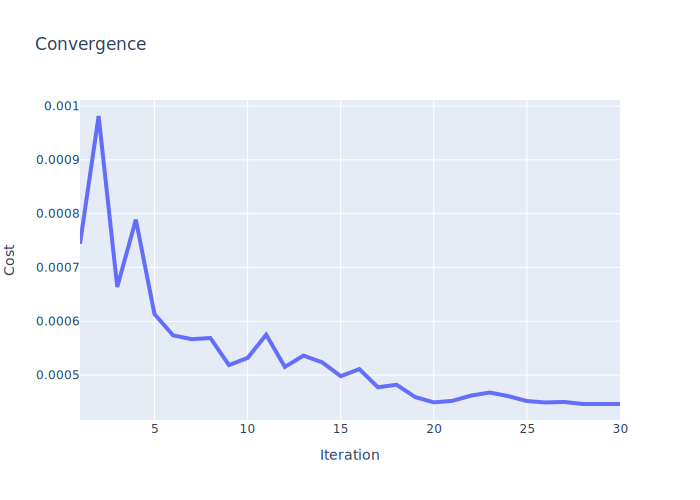

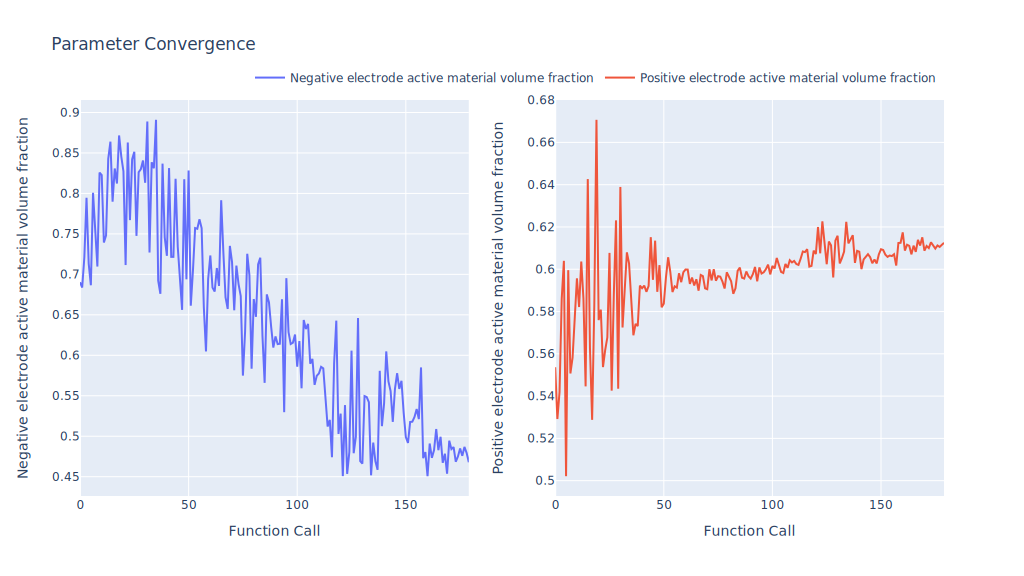

In [16]:
pybop.plot_convergence(optim)
pybop.plot_parameters(optim);

### Cost Landscape

Finally, we can visualise the cost landscape and the path taken by the optimiser:

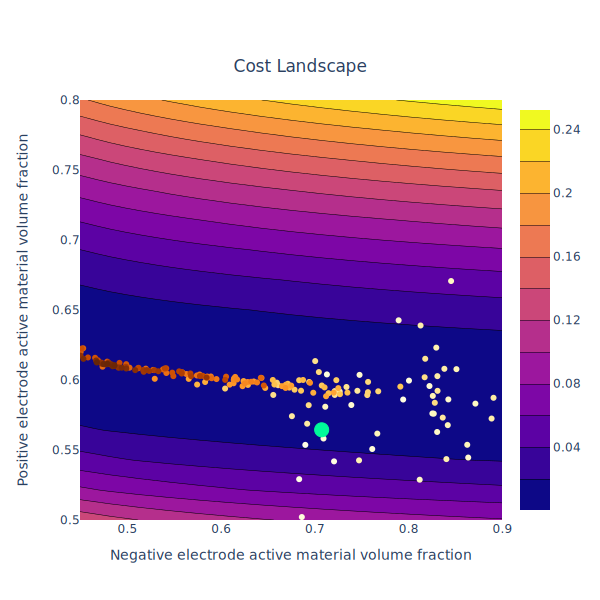

In [17]:
pybop.plot2d(optim, steps=15);